### 네이버 영화 리뷰 감성 분석

In [1]:
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

In [3]:
BASIC_PATH = "/dataset/"

In [5]:
TOTAL_RATINGS = '/rating.txt'
TRAIN_RATINGS = '/ratings_train.txt'
TEST_RATINGS = '/ratings_test.txt'

## [1] 데이터 분석

#### [1-] 파일 크기, 데이터 개수 확인

In [4]:
print("파일 크기 : ")
for file in os.listdir(BASIC_PATH):
    if 'txt' in file and 'zip' not in file:
        print(file.ljust(30) + str(round(os.path.getsize(BASIC_PATH+"/"+file) / 100000, 2)) + 'KB')

파일 크기 : 
ratings_test.txt              48.93KB
rating.txt                    195.15KB
stop_words.txt                0.02KB
ratings_train.txt             146.29KB


In [5]:
train_data = pd.read_csv(
    BASIC_PATH + TRAIN_RATINGS, header = 0, delimiter = '\t', quoting=3
)

In [6]:
train_data.head(5)

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [7]:
print("전체 학습데이터 개수 : {}".format(len(train_data)))

전체 학습데이터 개수 : 150000


In [8]:
test_data = pd.read_csv(
    BASIC_PATH + TEST_RATINGS, header = 0, delimiter = '\t', quoting=3
)

In [9]:
test_data.head(5)

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


In [10]:
print("전체 테스트 데이터 개수 : {}".format(len(test_data)))

전체 테스트 데이터 개수 : 50000


#### [1-2] 리뷰의 길이 확인

In [11]:
train_length = train_data['document'].astype('str').apply(len)

In [12]:
train_length.head()

0    19
1    33
2    17
3    29
4    61
Name: document, dtype: int64

/home/ai-sjjy/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: The 'nonposy' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  This is separate from the ipykernel package so we can avoid doing imports until


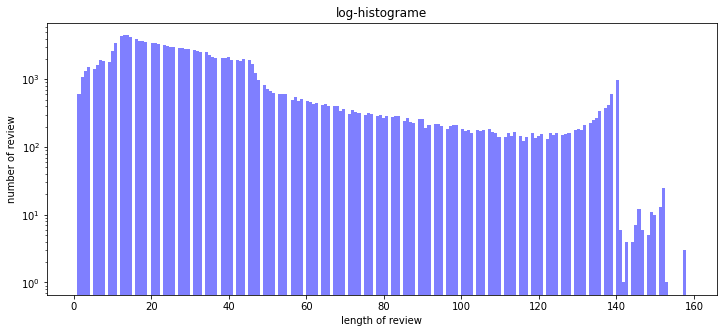

In [13]:
plt.figure(figsize=(12, 5))
plt.hist(train_length, bins=200, alpha=0.5, color='b', label='word')
plt.yscale('log', nonposy='clip')
plt.title('log-histograme')
plt.xlabel('length of review')
plt.ylabel('number of review')
plt.show()

#### [1-3] 긍정 부정 데이터 분포

/home/ai-sjjy/anaconda3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='label', ylabel='count'>

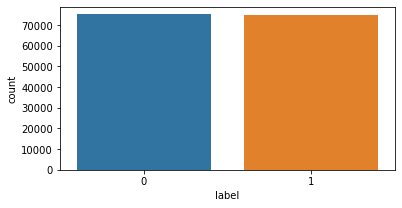

In [14]:
fig, axe = plt.subplots(ncols=1)
fig.set_size_inches(6, 3)
sns.countplot(train_data['label'])

In [15]:
print("긍정 리뷰 개수 : {}".format(train_data['label'].value_counts()[1]))
# 긍정 : 74825
print("부정 리뷰 개수 : {}".format(train_data['label'].value_counts()[0]))
# 부정 : 75170

긍정 리뷰 개수 : 74827
부정 리뷰 개수 : 75173


#### [1-4] 각 리뷰의 단어 개수 분포

/home/ai-sjjy/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: The 'nonposy' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  


Text(0, 0.5, 'number of reviews')

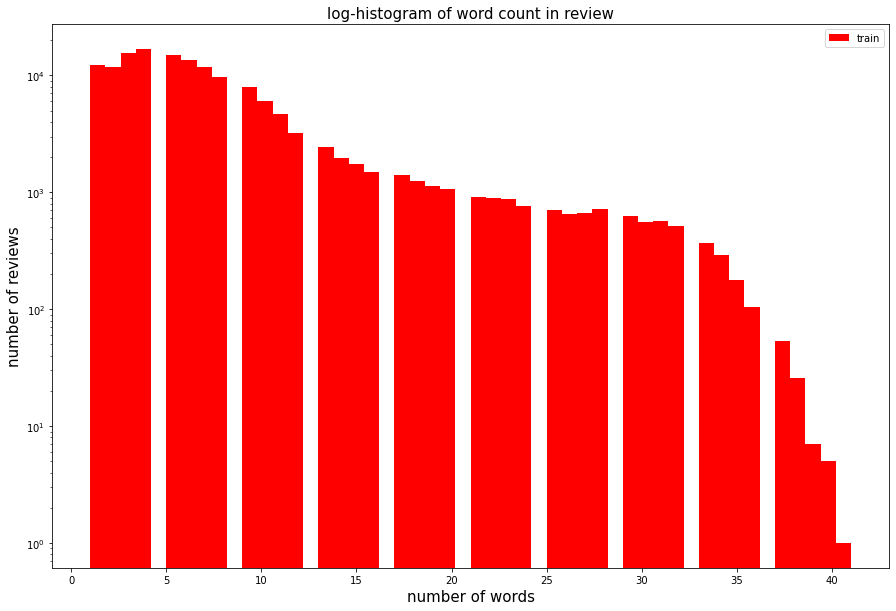

In [16]:
train_word_counts = train_data['document'].astype('str').apply(lambda x: len(x.split(' ')))

plt.figure(figsize=(15, 10))
plt.hist(train_word_counts, bins=50, facecolor='r', label='train')
plt.title('log-histogram of word count in review', fontsize=15)
plt.yscale('log', nonposy='clip')
plt.legend()
plt.xlabel('number of words', fontsize=15)
plt.ylabel('number of reviews', fontsize=15)

#### [1-5] 특수문자

In [17]:
qmarks = np.mean(train_data['document'].astype('str').apply(lambda x: '?' in x))
fullstop = np.mean(train_data['document'].astype('str').apply(lambda x: '.' in x))
numbers = np.mean(train_data['document'].astype('str').apply(lambda x: max([y.isdigit() for y in x])))


print("물음표 있는 질문 : {:.2f}%".format(qmarks * 100))
print("마침표 있는 질문 : {:.2f}%".format(fullstop * 100))
print("숫자가 있는 질문 : {:.2f}%".format(numbers * 100))

물음표 있는 질문 : 8.25%
마침표 있는 질문 : 51.76%
숫자가 있는 질문 : 13.62%


#### [1-6] 결측치 확인

In [18]:
train_data.isnull().sum()

id          0
document    5
label       0
dtype: int64

In [19]:
test_data.isnull().sum()

id          0
document    3
label       0
dtype: int64

In [20]:
train_data[train_data['document'].isnull()]

,id,document,label
25857,2172111,NaN,1
55737,6369843,NaN,1
110014,1034280,NaN,0
126782,5942978,NaN,0
140721,1034283,NaN,0


In [21]:
test_data[test_data['document'].isnull()]

,id,document,label
5746,402110,NaN,1
7899,5026896,NaN,0
27097,511097,NaN,1


* document가 없는 데이터는 필요 없다 => drop!

In [22]:
train_data = train_data[~train_data['document'].isnull()]

In [23]:
test_data = test_data[~test_data['document'].isnull()]

In [24]:
train_data.isnull().sum()

id          0
document    0
label       0
dtype: int64

In [25]:
test_data.isnull().sum()

id          0
document    0
label       0
dtype: int64

#### [1-7] 필요없는 속성 제거
=> id 제거

In [26]:
train_data = train_data[['document', 'label']]
test_data = test_data[['document', 'label']]

## [2] 데이터 전처리

1. 한글 및 공백을 제외한 모든 문자 제거 -> 한글만 남기겠다.
2. 띄어쓰기 규칙
3. mecab 객체를 활용해 형태소 단위로 문장을 나눈다(tokenzing)
4. 불용어 제거하기

In [27]:
import numpy as np
import pandas as pd
import os
import re
import json

from konlpy.tag import Mecab

from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from tensorflow.python.keras.preprocessing.text import Tokenizer
from hanspell import spell_checker

from pykospacing import Spacing
spacing = Spacing()

mecab = Mecab() #형태소 분석기 선언


In [28]:
stop_words = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

#### [2-1] 데이터 전처리 진행 1

In [29]:
def preprocessing(review, spell, remove_stopwords = False, stop_words = []):    
    # 1. 한글 및 공백을 제외한 모든 문자 제거 -> 한글만 남기겠다.
    review_text = re.sub("[^가-힣ㄱ-ㅎㅏ - | \\s]", "", review)
    
    # 2. 띄어쓰기 규칙
    review_text = spacing(review_text)
    
    # 3. mecab 객체를 활용해 형태소 단위로 문장을 나눈다(tokenzing)
    word_review = mecab.morphs(review_text)
    
    # 4. 불용어 제거하기
    if remove_stopwords:
        word_review = [token for token in word_review if not token in stop_words]
    
    return word_review

In [30]:
clean_train_review = []

from tqdm import tqdm

for review in tqdm(train_data['document']):
    clean_train_review.append(preprocessing(review, False, remove_stopwords = True, stop_words = stop_words))

100%|██████████| 149995/149995 [1:09:30<00:00, 35.96it/s]


In [31]:
print("전체 리뷰 개수 : ", len(clean_train_review))
print("띄어쓰기 이상한 리뷰 제거한 개수 :", len([clean for clean in clean_train_review if clean]))

전체 리뷰 개수 :  149995
띄어쓰기 이상한 리뷰 제거한 개수 : 148669


In [32]:
for idx, clean in enumerate(clean_train_review):
    if clean == None: continue
    if clean == []:
        clean_train_review[idx] = None
    else:
        clean_train_review[idx] = " ".join(clean)

In [34]:
clean_test_review = []

for review in tqdm(test_data['document']):
    clean_test_review.append(preprocessing(review, False, remove_stopwords = True, stop_words = stop_words))

100%|██████████| 49997/49997 [23:09<00:00, 35.99it/s]


In [35]:
print("전체 리뷰 개수 : ", len(clean_test_review))
print("띄어쓰기 이상한 리뷰 제거한 개수 :", len([clean for clean in clean_test_review if clean]))

전체 리뷰 개수 :  49997
띄어쓰기 이상한 리뷰 제거한 개수 : 49549


In [36]:
for idx, clean in enumerate(clean_test_review):
    if clean == None: continue
    if clean == []:
        clean_test_review[idx] = None
    else:
        clean_test_review[idx] = " ".join(clean)

#### [2-2] 띄어쓰기 이상한 리뷰 제거

In [37]:
train_data['document'] = clean_train_review

In [38]:
train_data.isnull().sum()

document    1326
label          0
dtype: int64

In [39]:
train_data = train_data[~train_data['document'].isnull()]

In [40]:
train_data.isnull().sum()

document    0
label       0
dtype: int64

In [41]:
print("전체 리뷰 개수 : ", len(train_data))

전체 리뷰 개수 :  148669


In [42]:
train_data

,document,label
0,아 더빙 진짜 짜증 나 네요 목소리,0
1,흠 포스터 보고 초딩 영화 줄 오버 연기 조차 가볍 지 않 구나,1
2,너무 재 밓었다 그래서 보 것 을 추천 한다,0
3,교도소 이야기 구먼 솔직히 재미 없 다 평점 조정,0
4,사이몬 페그 익살 스런 연기 돋보였 던 영화 스파이더맨 에서 늙 어 보이 기 만 했...,1
...,...,...
149995,인간 문제지 소 뭔 죄 인가,0
149996,평점 너무 낮 아서,1
149997,이게 뭐 요 한국인 거들 먹거리 고 필리핀 혼혈 착하 다,0
149998,청춘 영화 최고봉 방황 우울 했 던 날 자화상,1


In [43]:
test_data['document'] = clean_test_review

In [44]:
test_data.isnull().sum()

document    448
label         0
dtype: int64

In [45]:
test_data = test_data[~test_data['document'].isnull()]

In [46]:
test_data.isnull().sum()

document    0
label       0
dtype: int64

In [47]:
print("전체 리뷰 개수 : ", len(test_data))

전체 리뷰 개수 :  49549


In [48]:
train_data.to_csv(BASIC_PATH + 'clean_train1.csv', index=False)
test_data.to_csv(BASIC_PATH + 'clean_test1.csv', index=False)

## [3] 정수 임베딩

In [4]:
## 만약에 위에 clean code 지나치고 싶으면
CLEAN_TRAIN = "clean1/clean_train1.csv"
CLEAN_TEST = "clean1/clean_test1.csv"

train_data = pd.read_csv(BASIC_PATH+CLEAN_TRAIN)
test_data = pd.read_csv(BASIC_PATH+CLEAN_TEST)

In [5]:
X_train = train_data['document'].tolist()
X_train = [x.split() for x in X_train]
y_train = np.array(list(train_data['label'].tolist()))

In [6]:
X_test = test_data['document'].tolist()
X_test = [x.split() for x in X_test]
y_test = np.array(list(test_data['label'].tolist()))

In [7]:
print(X_train[5])

['막', '걸음마', '뗀', '세', '부터', '초등', '학교', '학년', '생', '인', '살용', '영화', 'ㅋㅋㅋ', '별반', '개', '아까움']


### [3-1] Keras Tokenizer 사용

* X_train1 로 저장!
* X_test1 로 저장!

In [8]:
X_train1 = X_train.copy()
X_test1 = X_test.copy()
y_train1 = y_train.copy()
y_test1 = y_test.copy()

In [9]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [10]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train1)

In [11]:
print("총 단어 개수 :", len(tokenizer.word_index)) # 총 단어 개수 : 44610

총 단어 개수 : 44610


In [12]:
threshold = 3 # 빈도 수는 2번이상인 단어 기준
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 44610
등장 빈도가 2번 이하인 희귀 단어의 수: 23921
단어 집합에서 희귀 단어의 비율: 53.6225061645371
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 1.4797711102577327


In [13]:
vocab_size = total_cnt - rare_cnt + 1
print('단어 집합의 크기 :',vocab_size) # 단어 집합의 크기 : 27095

단어 집합의 크기 : 20690


In [14]:
tokenizer = Tokenizer(vocab_size) # index 번호 부여가 빈도수 기반으로 했기 때문에 해당 vocab까지 자르기
tokenizer.fit_on_texts(X_train1)
X_train1 = tokenizer.texts_to_sequences(X_train1)
X_test1 = tokenizer.texts_to_sequences(X_test1)

In [15]:
print(X_train1[0])  # 1번째 리뷰데이터
print('라벨: ', y_train1[0])  # 1번째 리뷰데이터의 라벨
print('1번째 리뷰 문장 길이: ', len(X_train1[0]))

[25, 492, 32, 215, 12, 29, 706]
라벨:  0
1번째 리뷰 문장 길이:  7


##### 빈 샘플 제거

In [16]:
drop_train = [index for index, sentence in enumerate(X_train1) if len(sentence) < 1]
X_train1 = np.delete(X_train1, drop_train, axis=0)
y_train1 = np.delete(y_train1, drop_train, axis=0)

print(X_train1.shape)
print(len(y_train1))

(148554,)
148554


/home/ai-sjjy/anaconda3/envs/juyoung/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


#### [3-1-1] 임베딩 최대 길이 지정

In [17]:
total_data_text = list(X_train1) + list(X_test1)

# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)

# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

문장길이 평균 :  13.584498972756597
문장길이 최대 :  82
문장길이 표준편차 :  11.497375138961875


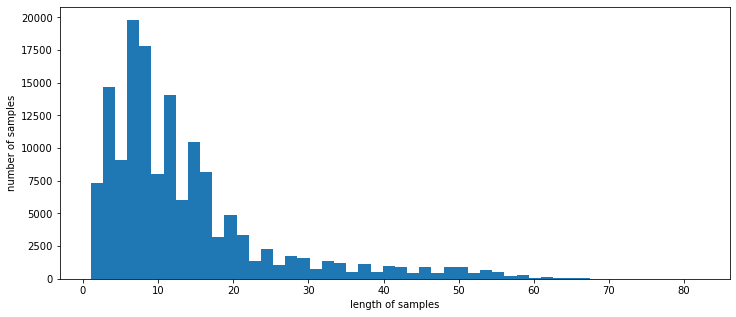

In [18]:
plt.figure(figsize=(12, 5))
plt.hist([len(s) for s in X_train1], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [19]:
# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_len = 50
print('pad_sequences maxlen : ', max_len)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_len) / len(num_tokens)))

pad_sequences maxlen :  50
전체 문장의 0.9761790583686264%가 maxlen 설정값 이내에 포함됩니다. 


#### [3-1-2] 패딩

In [20]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

X_train1 = pad_sequences(X_train1, maxlen = max_len)
X_test1 = pad_sequences(X_test1, maxlen = max_len)

In [21]:
# 데이터셋 정제 후 데이터셋 shape 확인
print(X_train1.shape)
print(X_test1.shape)

(148554, 50)
(49549, 50)


In [22]:
data_config = {
    'max_len' : max_len,
    'vocab_size' : vocab_size
}

In [23]:
import json

json.dump(data_config, open(BASIC_PATH + 'clean1/data_configs_token1.json', 'w'), ensure_ascii=False)

In [24]:
# tokenizer 저장
import pickle

with open(BASIC_PATH+'clean1/basic_tokenizer1.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

### [3-2] TF-IDF

* X_train2로 저장!
* X_test2로 저장!

* tf-idf에서는 input이 ['막', '걸음마', '뗀', '세', '부터', '초등', '학교', '학년', '생', '인', '살용', '영화', 'ㅋㅋㅋ', '별반', '개', '아까움'] 이런 토큰 형태가 아닌, 문장이어야 한다

In [74]:
X_train2 = [" ".join(x) for x in X_train]
X_test2 = [" ".join(x) for x in X_test]
y_train2 = y_train.copy()
y_test2 = y_test.copy()

In [75]:
print(X_train2[5])

막 걸음마 뗀 세 부터 초등 학교 학년 생 인 살용 영화 ㅋㅋㅋ 별반 개 아까움


In [76]:
print(X_test2[5])

진정 쓰레기


In [77]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [78]:
vectorizer = TfidfVectorizer(ngram_range=(1,1), min_df=2, analyzer="word", sublinear_tf=True) # 최소 2번이상

X_train2 = vectorizer.fit_transform(X_train2)
X_test2 = vectorizer.transform(X_test2)

In [81]:
vectorizer.get_feature_names()[:16]

['ㄲㄲ',
 'ㄲㄲㄲ',
 'ㄲㅇ',
 'ㄲㅈ',
 'ㄲㅈㅁ',
 'ㄲㅋ',
 'ㄲ가',
 'ㄲ들',
 'ㄳㄳ',
 'ㄴ나',
 'ㅃㅏ',
 'ㅄ들아',
 'ㅄ이',
 'ㅄ임',
 'ㅆㄹ',
 'ㅆㄹㄱ']

In [82]:
print("총 단어 개수 :", len(vectorizer.vocabulary_)) # 총 단어 개수 : 42556
print("총 단어 개수 :", len(vectorizer.get_feature_names())) # 총 단어 개수 : 42556

총 단어 개수 : 25035
총 단어 개수 : 25035


In [83]:
print(X_train2.shape)

(148669, 25035)


In [84]:
print(X_test2.shape)

(49549, 25035)


In [85]:
# tokenizer 저장
import pickle

with open(BASIC_PATH+'clean1/basic_tf-idf1.pickle', 'wb') as handle:
    pickle.dump(vectorizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

### [3-3] Word2Vec

* X_train3로 저장!
* X_test3로 저장!

* 미리 학습된 Word2Vec

한국어 Word2Vec 사용

word2vec_path = BASIC_PATH+'ko.bin'

word2vec = Word2Vec.load(word2vec_path)

In [33]:
X_train3 = X_train.copy()
X_test3 = X_test.copy()
y_train3 = y_train.copy()
y_test3 = y_test.copy()

In [44]:
from gensim.models import Word2Vec

In [45]:
# 학습 시 필요한 하이퍼 파라미터

num_features = 200 # 워드 백터 특정값 수 -> 임베딩 차원 수 지정
min_word_count = 2 # 단어에 대한 최소 빈도 수 -> 빈도수가 적은 단어들은 학습 x
num_workers = 4 # 프로세스 개수 
context = 10 # 컨텍스트 윈도우 크기
downsampling = 1e-3 # 다운 샘플링 비율

In [46]:
w2_model = Word2Vec(X_train3, workers=num_workers, \
                         vector_size=num_features, min_count = min_word_count, \
                         window = context, sample = downsampling)

In [50]:
def get_feature(words, model, num_feature):
    # 우리는 num_feature 차원의 벡터 크기를 만들거임
    feature_vector = np.zeros((num_features), dtype=np.float32) # feature_vector 초기화
    
    num_words = 0
    
    # index2word_set -> 문장 속 단어가 모델 단어 사전에 있는지 보기 위해 어휘 사전 부름
    index2word_set = set(model.wv.index_to_key) # 어휘 사전 준비
    
    for w in words:
        if w in index2word_set: # 단어가 모델 단어 사전에 있으면
            num_words += 1
            feature_vector = np.add(feature_vector, model.wv[w]) #wv[w] -> 해당 단어의 임베딩 벡터 가져와 모든 벡터들의 합을 구함
    # 평균을 내기 위해서 feature vector / num_words(단어 사전에 있는 단어들)한다
    feature_vector = np.divide(feature_vector, num_words) if num_words else np.zeros((num_features), dtype=np.float32)
        
    return feature_vector

In [51]:
def get_dataset(sentences, model, num_features):
    dataset = list()
    
    for s in sentences: # 한 문서씩 꺼냄 (단어 배열 형태 임)
        dataset.append(get_feature(s, model, num_features)) # 이 단어 배열들을 임베딩 함
        
    #reviewFeatureVecs = np.stack(dataset)
    return dataset

In [52]:
# X 벡터화-임베딩ㅇ 진행 -> 실제 학습에 사용될 입력값을 만들어 보자.
X_train3= get_dataset(X_train3, w2_model, num_features)
X_test3= get_dataset(X_test3, w2_model, num_features)

In [53]:
print(len(X_train3))
print(len(y_train3))

148669
148669


In [54]:
drop_train = []
for idx, x in enumerate(X_train3):
    try:
        if x.all: pass
    except:
        drop_train.append(idx)

X_train3 = np.delete(X_train3, drop_train, axis=0)
y_train3 = np.delete(y_train3, drop_train, axis=0)

print(len(X_train3))
print(len(y_train3))

X_train3 = np.stack(X_train3)

148669
148669


In [55]:
drop_train = []
for idx, x in enumerate(X_test3):
    try:
        if x.all: pass
    except:
        drop_train.append(idx)

X_test3 = np.delete(X_test3, drop_train, axis=0)
y_test3 = np.delete(y_test3, drop_train, axis=0)

print(len(X_test3))
print(len(y_test3))

X_test3 = np.stack(X_test3)

49549
49549


In [56]:
w2_model.save(BASIC_PATH+'clean1/Word2vec1.model')

## [4] train data split 진행

#### (1) X_train1, X_val1, X_test1 => Ketas tokenizer 이용

In [25]:
from sklearn.model_selection import train_test_split # 데이터 셋 분할

TEST_SPLIT = 0.2

X_train1, X_val1, y_train1, y_val1 = train_test_split(X_train1, y_train1, test_size=TEST_SPLIT)

In [26]:
print(X_train1.shape)
print(X_val1.shape)

(118843, 50)
(29711, 50)


In [27]:
X_train1[0]

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 15, 15, 28,  7, 19, 53],
      dtype=int32)

#### (2) X_train1, X_val1, X_test1 => TF-IDF tokenizer 이용

In [ ]:
X_train2, X_val2, y_train2, y_val2 = train_test_split(X_train2, y_train2, test_size=TEST_SPLIT, random_state=RANDOM_SEED)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/ai-sjjy/anaconda3/envs/juyoung/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3343, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-29-436799be20b4>", line 1, in <module>
    X_train2, X_val2, y_train2, y_val2 = train_test_split(X_train2, y_train2, test_size=TEST_SPLIT, random_state=RANDOM_SEED)
NameError: name 'X_train2' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/ai-sjjy/anaconda3/envs/juyoung/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2044, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'NameError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/ai-sjjy/anaconda3/envs/juyoung/lib/python3.6/site-packages/IPython/core/ultratb.

In [87]:
print(X_train2.shape)
print(X_val2.shape)

(118935, 25035)
(29734, 25035)


In [88]:
X_train2[0]

<1x25035 sparse matrix of type '<class 'numpy.float64'>'
	with 0 stored elements in Compressed Sparse Row format>

In [89]:
X_train2 = X_train2.toarray()
X_test2 = X_test2.toarray()

#### (3) X_train1, X_val1, X_test1 => Word2Vec tokenizer 이용

In [64]:
X_train3, X_val3, y_train3, y_val3 = train_test_split(X_train3, y_train3, test_size=TEST_SPLIT, random_state=RANDOM_SEED)

In [65]:
print(X_train3.shape)
print(X_val3.shape)

(118935, 200)
(29734, 200)


## [5] 모델 설정 및 훈련

### [5-1] 머신러닝 모델

* Naive Bayes Classification
* Support Vector Machine
* Random Fores
* XG Boost

### [5-1-1] Naive Bayes Classification

#### (1) X_train1, X_val1, X_test1 => Ketas tokenizer 이용

In [25]:
from sklearn.naive_bayes import MultinomialNB # 다항분포 나이브 베이즈 모델
from sklearn.metrics import accuracy_score #정확도 계산

nb1 = MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
nb1.fit(X_train1, y_train1)

MultinomialNB()

In [28]:
predicted1 = nb1.predict(X_val1)
print("Accuracy : %f" % nb1.score(X_val1, y_val1)) # score()함수 => 정확도 측정

Accuracy : 0.499731


In [29]:
print("Accuracy : %f" % nb1.score(X_test1, y_test1)) # score()함수 => 정확도 측정

Accuracy : 0.506347


#### (2) X_train1, X_val1, X_test1 => TF-IDF tokenizer 이용

In [90]:
nb2 = MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
nb2.fit(X_train2, y_train2)

MultinomialNB()

In [91]:
predicted1 = nb2.predict(X_val2)
print("Accuracy : %f" % nb2.score(X_val2, y_val2)) # score()함수 => 정확도 측정

Accuracy : 0.805475


In [92]:
print("Accuracy : %f" % nb2.score(X_test2, y_test2)) # score()함수 => 정확도 측정

Accuracy : 0.808271


#### (3) X_train1, X_val1, X_test1 => Word2Vec tokenizer 이용

In [93]:
nb3 = MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
nb3.fit(X_train3, y_train3)

ValueError: Negative values in data passed to MultinomialNB (input X)

### [5-2] 딥러닝 모델

* LSTM
* CNN
* BiLSTM
* GRU
* CNN+LSTM


|모델|정확도|
|---|---|
|lstm|85.9%|
|cnn|85.6%|
|bilsm|85.8%|
|gru|85.7%|
|cnn+lstm|%|

### [5-2] LSTM

#### (1) X_train1, X_val1, X_test1 => Ketas tokenizer 이용

In [28]:
from tensorflow.keras.layers import Embedding, Dense, LSTM, Dropout, Conv1D, GlobalMaxPooling1D, Input, Flatten, Concatenate, Bidirectional, MaxPooling1D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


In [29]:
vocab_size, word_vector_dim = vocab_size, 100

In [30]:
lstm = Sequential()
lstm.add(Embedding(vocab_size, word_vector_dim))
lstm.add(LSTM(128))
lstm.add(Dense(1, activation='sigmoid'))

In [31]:
es1 = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc1 = ModelCheckpoint('lstm_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)
lstm.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

#### (1) X_train1, X_val1, X_test1 => Ketas tokenizer 이용

In [32]:
epochs=20

history = lstm.fit(X_train1, y_train1,
                    epochs=epochs,
                    batch_size=64, # 512, 100, 60 
                    validation_data=(X_val1, y_val1),
                    verbose=1,
                    callbacks = [es1, mc1])

Train on 118843 samples, validate on 29711 samples
Epoch 1/20
118843/118843 [==============================] - 53s 449us/sample - loss: 0.3872 - accuracy: 0.8263 - val_loss: 0.3457 - val_accuracy: 0.8441
Epoch 2/20
118843/118843 [==============================] - 47s 400us/sample - loss: 0.3189 - accuracy: 0.8631 - val_loss: 0.3230 - val_accuracy: 0.8601
Epoch 3/20
118843/118843 [==============================] - 48s 403us/sample - loss: 0.2927 - accuracy: 0.8778 - val_loss: 0.3127 - val_accuracy: 0.8661
Epoch 4/20
118843/118843 [==============================] - 48s 403us/sample - loss: 0.2726 - accuracy: 0.8877 - val_loss: 0.3138 - val_accuracy: 0.8647
Epoch 5/20
118843/118843 [==============================] - 48s 401us/sample - loss: 0.2555 - accuracy: 0.8966 - val_loss: 0.3151 - val_accuracy: 0.8634
Epoch 6/20
118843/118843 [==============================] - 48s 404us/sample - loss: 0.2394 - accuracy: 0.9044 - val_loss: 0.3176 - val_accuracy: 0.8628
Epoch 7/20
118843/118843 [=====

In [33]:
results = lstm.evaluate(X_test1, y_test1, verbose=1)

print(results)

49549/49549 [==============================] - 6s 117us/sample - loss: 0.3302 - accuracy: 0.8591
[0.33021391963878266, 0.85912937]


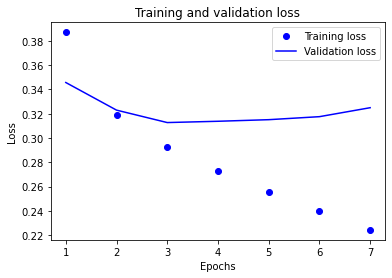

In [34]:
history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [35]:
## 모델 저장
lstm.save(BASIC_PATH + 'clean1/lstm_model1.h5')

### [5-2] CNN

In [36]:
dropout_prob = 0.5
num_filters = 128

In [38]:
cnn = Sequential()
cnn.add(Embedding(vocab_size, word_vector_dim))

# cnn
cnn.add(Dropout(dropout_prob))
cnn.add(Conv1D(num_filters, 3, padding='valid', activation='relu', strides = 1))
cnn.add(MaxPooling1D(3))
cnn.add(Conv1D(num_filters, 4, padding='valid', activation='relu', strides = 1))
cnn.add(GlobalMaxPooling1D())
cnn.add(Dense(128, activation='relu'))
cnn.add(Dropout(dropout_prob))
cnn.add(Dense(1, activation='sigmoid'))


#### (1) X_train1, X_val1, X_test1 => Ketas tokenizer 이용

In [39]:
es2 = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc2 = ModelCheckpoint('CNN_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

cnn.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=["acc"])

history_cnn = cnn.fit(X_train1, y_train1, batch_size = 64, epochs=20,\
                        validation_data = (X_val1, y_val1), verbose=1, callbacks=[es2, mc2])

Train on 118843 samples, validate on 29711 samples
Epoch 1/20
118720/118843 [============================>.] - ETA: 0s - loss: 0.4164 - acc: 0.8063
Epoch 00001: val_acc improved from -inf to 0.84359, saving model to CNN_model.h5
118843/118843 [==============================] - 48s 400us/sample - loss: 0.4164 - acc: 0.8064 - val_loss: 0.3548 - val_acc: 0.8436
Epoch 2/20
118784/118843 [============================>.] - ETA: 0s - loss: 0.3513 - acc: 0.8497
Epoch 00002: val_acc improved from 0.84359 to 0.84531, saving model to CNN_model.h5
118843/118843 [==============================] - 46s 388us/sample - loss: 0.3514 - acc: 0.8497 - val_loss: 0.3534 - val_acc: 0.8453
Epoch 3/20
118720/118843 [============================>.] - ETA: 0s - loss: 0.3345 - acc: 0.8608
Epoch 00003: val_acc improved from 0.84531 to 0.85558, saving model to CNN_model.h5
118843/118843 [==============================] - 46s 389us/sample - loss: 0.3345 - acc: 0.8608 - val_loss: 0.3359 - val_acc: 0.8556
Epoch 4/20
11

In [40]:
results = cnn.evaluate(X_test1, y_test1, verbose=2)

print(results)

49549/49549 - 4s - loss: 0.3457 - acc: 0.8569
[0.34568683966050273, 0.856869]


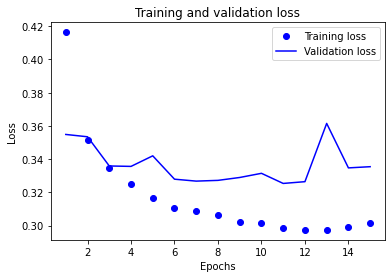

In [41]:
history_dict = history_cnn.history

acc = history_dict['acc']
val_acc = history_dict['val_acc']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [42]:
## 모델 저장
cnn.save(BASIC_PATH + 'clean1/CNN_model1.h5')

### [5-3] Bi-LSTM

In [43]:
bilstm = Sequential()
bilstm.add(Embedding(vocab_size, word_vector_dim))
bilstm.add(Bidirectional(LSTM(128)))
bilstm.add(Dense(1, activation='sigmoid'))

In [44]:
es3 = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc3 = ModelCheckpoint('bilstm_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [45]:
bilstm.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
history_bilstm = bilstm.fit(X_train1, y_train1, epochs=15, callbacks=[es3, mc3], \
                            batch_size=64, validation_data = (X_val1, y_val1), verbose=1)

Train on 118843 samples, validate on 29711 samples
Epoch 1/15
118720/118843 [============================>.] - ETA: 0s - loss: 0.3886 - accuracy: 0.8251WARNING:tensorflow:Can save best model only with val_acc available, skipping.


118843/118843 [==============================] - 54s 455us/sample - loss: 0.3885 - accuracy: 0.8252 - val_loss: 0.3435 - val_accuracy: 0.8484
Epoch 2/15
118720/118843 [============================>.] - ETA: 0s - loss: 0.3211 - accuracy: 0.8616WARNING:tensorflow:Can save best model only with val_acc available, skipping.


118843/118843 [==============================] - 51s 427us/sample - loss: 0.3211 - accuracy: 0.8617 - val_loss: 0.3232 - val_accuracy: 0.8595
Epoch 3/15
118720/118843 [============================>.] - ETA: 0s - loss: 0.2955 - accuracy: 0.8756WARNING:tensorflow:Can save best model only with val_acc available, skipping.


118843/118843 [==============================] - 51s 425us/sample - loss: 0.2955 - accuracy: 0.8755 - val_loss: 0.3240 - val_accuracy: 0.8582
Epoch 4/15
118720/118843 [============================>.] - ETA: 0s - loss: 0.2759 - accuracy: 0.8868WARNING:tensorflow:Can save best model only with val_acc available, skipping.


118843/118843 [==============================] - 51s 428us/sample - loss: 0.2759 - accuracy: 0.8868 - val_loss: 0.3134 - val_accuracy: 0.8668
Epoch 5/15
118784/118843 [============================>.] - ETA: 0s - loss: 0.2591 - accuracy: 0.8944WARNING:tensorflow:Can save best model only with val_acc available, skipping.


118843/118843 [==============================] - 51s 425us/sample - loss: 0.2590 - accuracy: 0.8944 - val_loss: 0.3155 - val_accuracy: 0.8643
Epoch 6/15
118784/118843 [============================>.] - ETA: 0s - loss: 0.2435 - accuracy: 0.9016WARNING:tensorflow:Can save best model only with val_acc available, skipping.


118843/118843 [==============================] - 51s 426us/sample - loss: 0.2436 - accuracy: 0.9016 - val_loss: 0.3199 - val_accuracy: 0.8622
Epoch 7/15
118656/118843 [============================>.] - ETA: 0s - loss: 0.2286 - accuracy: 0.9093WARNING:tensorflow:Can save best model only with val_acc available, skipping.


118843/118843 [==============================] - 51s 427us/sample - loss: 0.2286 - accuracy: 0.9093 - val_loss: 0.3399 - val_accuracy: 0.8561
Epoch 8/15
118784/118843 [============================>.] - ETA: 0s - loss: 0.2135 - accuracy: 0.9161WARNING:tensorflow:Can save best model only with val_acc available, skipping.


118843/118843 [==============================] - 51s 429us/sample - loss: 0.2135 - accuracy: 0.9161 - val_loss: 0.3323 - val_accuracy: 0.8607
Epoch 00008: early stopping


In [46]:
print("테스트 정확도: %.4f" % (bilstm.evaluate(X_test1, y_test1)[1]))

49549/49549 [==============================] - 7s 143us/sample - loss: 0.3350 - accuracy: 0.8588
테스트 정확도: 0.8588


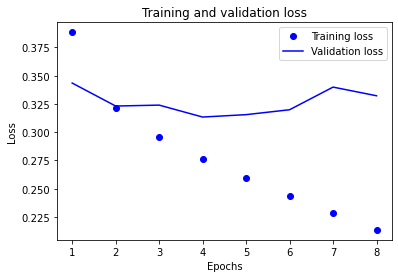

In [47]:
history_dict = history_bilstm.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [48]:
## 모델 저장
bilstm.save(BASIC_PATH + 'clean1/BILSTM_model1.h5')

### [5-4] GRU

In [49]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, Embedding
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [50]:
gru = Sequential()
gru.add(Embedding(vocab_size, word_vector_dim))
gru.add(GRU(128))
gru.add(Dense(1, activation='sigmoid'))

In [51]:
es4 = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc4 = ModelCheckpoint('GRU_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [52]:
gru.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
history_gru = gru.fit(X_train1, y_train1, epochs=15, callbacks=[es4, mc4], batch_size=64,\
                      validation_data = (X_val1, y_val1), verbose=1)

Train on 118843 samples, validate on 29711 samples
Epoch 1/15
118784/118843 [============================>.] - ETA: 0s - loss: 0.3812 - accuracy: 0.8286WARNING:tensorflow:Can save best model only with val_acc available, skipping.


118843/118843 [==============================] - 52s 434us/sample - loss: 0.3812 - accuracy: 0.8286 - val_loss: 0.3415 - val_accuracy: 0.8502
Epoch 2/15
118784/118843 [============================>.] - ETA: 0s - loss: 0.3189 - accuracy: 0.8637WARNING:tensorflow:Can save best model only with val_acc available, skipping.


118843/118843 [==============================] - 48s 404us/sample - loss: 0.3190 - accuracy: 0.8637 - val_loss: 0.3273 - val_accuracy: 0.8570
Epoch 3/15
118656/118843 [============================>.] - ETA: 0s - loss: 0.2933 - accuracy: 0.8769WARNING:tensorflow:Can save best model only with val_acc available, skipping.


118843/118843 [==============================] - 48s 404us/sample - loss: 0.2933 - accuracy: 0.8769 - val_loss: 0.3218 - val_accuracy: 0.8621
Epoch 4/15
118720/118843 [============================>.] - ETA: 0s - loss: 0.2717 - accuracy: 0.8881WARNING:tensorflow:Can save best model only with val_acc available, skipping.


118843/118843 [==============================] - 48s 400us/sample - loss: 0.2716 - accuracy: 0.8882 - val_loss: 0.3164 - val_accuracy: 0.8640
Epoch 5/15
118720/118843 [============================>.] - ETA: 0s - loss: 0.2535 - accuracy: 0.8971WARNING:tensorflow:Can save best model only with val_acc available, skipping.


118843/118843 [==============================] - 48s 401us/sample - loss: 0.2535 - accuracy: 0.8972 - val_loss: 0.3162 - val_accuracy: 0.8644
Epoch 6/15
118720/118843 [============================>.] - ETA: 0s - loss: 0.2368 - accuracy: 0.9057WARNING:tensorflow:Can save best model only with val_acc available, skipping.


118843/118843 [==============================] - 48s 404us/sample - loss: 0.2368 - accuracy: 0.9057 - val_loss: 0.3274 - val_accuracy: 0.8629
Epoch 7/15
118784/118843 [============================>.] - ETA: 0s - loss: 0.2201 - accuracy: 0.9135WARNING:tensorflow:Can save best model only with val_acc available, skipping.


118843/118843 [==============================] - 48s 406us/sample - loss: 0.2201 - accuracy: 0.9135 - val_loss: 0.3275 - val_accuracy: 0.8608
Epoch 8/15
118784/118843 [============================>.] - ETA: 0s - loss: 0.2041 - accuracy: 0.9209WARNING:tensorflow:Can save best model only with val_acc available, skipping.


118843/118843 [==============================] - 47s 397us/sample - loss: 0.2040 - accuracy: 0.9209 - val_loss: 0.3535 - val_accuracy: 0.8504
Epoch 9/15
118656/118843 [============================>.] - ETA: 0s - loss: 0.1878 - accuracy: 0.9279WARNING:tensorflow:Can save best model only with val_acc available, skipping.


118843/118843 [==============================] - 48s 404us/sample - loss: 0.1878 - accuracy: 0.9279 - val_loss: 0.3514 - val_accuracy: 0.8594
Epoch 00009: early stopping


In [53]:
print("테스트 정확도: %.4f" % (gru.evaluate(X_test1, y_test1)[1]))

49549/49549 [==============================] - 6s 112us/sample - loss: 0.3588 - accuracy: 0.8572
테스트 정확도: 0.8572


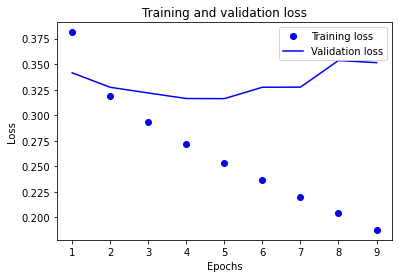

In [54]:
history_dict = history_gru.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [55]:
## 모델 저장
gru.save(BASIC_PATH + 'clean1/GRU_model1.h5')

### [5-5] CNN-LSTM